In [104]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from io import StringIO
import plotly

# Import API key
import config
from config import api_key


# Create dataframes from csv files
df_2017 = pd.read_csv("Data/PrescribingRate2017.csv", encoding="ISO-8859-1")
df_2016 = pd.read_csv("Data/PrescribingRate2016.csv", encoding="ISO-8859-1")
df_2015 = pd.read_csv("Data/PrescribingRate2015.csv", encoding="ISO-8859-1")
df_2014 = pd.read_csv("Data/PrescribingRate2014.csv", encoding="ISO-8859-1")
df_2013 = pd.read_csv("Data/PrescribingRate2013.csv", encoding="ISO-8859-1")
df_2012 = pd.read_csv("Data/PrescribingRate2012.csv", encoding="ISO-8859-1")
df_2011 = pd.read_csv("Data/PrescribingRate2011.csv", encoding="ISO-8859-1")
df_2010 = pd.read_csv("Data/PrescribingRate2010.csv", encoding="ISO-8859-1")
df_2009 = pd.read_csv("Data/PrescribingRate2009.csv", encoding="ISO-8859-1")
df_2008 = pd.read_csv("Data/PrescribingRate2008.csv", encoding="ISO-8859-1")
df_2007 = pd.read_csv("Data/PrescribingRate2007.csv", encoding="ISO-8859-1")
df_2006 = pd.read_csv("Data/PrescribingRate2006.csv", encoding="ISO-8859-1")
df_uszips = pd.read_csv("Data/uszips.csv", encoding="ISO-8859-1",converters={'zip': '{:0>5}'.format}) #this format adds zeros to zip if >5 digits
df_deaths = pd.read_csv("Data/CDC_Data.csv", encoding="ISO-8859-1")
df_opioid_deaths = pd.read_csv("Data/CDC_Overdose_Deaths_1999_to_2017_OPIOID ONLY.csv", encoding="ISO-8859-1")


#-----------------------------------------------------#
#------------Data Munging/Cleaning/Merging------------#
#-----------------------------------------------------#

# First check that files being merged have same column header names
list(df_2017) == list(df_2016)
list(df_2017)

['Year',
 'County',
 'State',
 'State/County FIPS Code',
 'Opioid Prescribing Rate per 100']

In [2]:
# Rename columns of 2017 dataframe to match for merge
columns_renamed = {'Year': 'Year',
 'County': 'County',
 'State': 'State',
 'State/County FIPS Code': 'FIPS County Code',
 'Opioid Prescribing Rate per 100': 'Opioid Prescribing Rate per 100'}

df_2017 = df_2017.rename(columns=columns_renamed)
list(df_2017)

['Year',
 'County',
 'State',
 'FIPS County Code',
 'Opioid Prescribing Rate per 100']

In [3]:
# Check that column names across all dataframes are uniform
list(df_2017) == list(df_2016) == list(df_2015) == list(df_2014) == list(df_2013) == list(df_2012) == list(df_2011) == list(df_2010) \
== list(df_2009) == list(df_2008) == list(df_2007) == list(df_2006)

True

In [4]:
# Since column names are all the same, we can use concatinate to merge all files
merged_df = pd.concat([df_2017, df_2016, df_2015, df_2014, df_2013, df_2012, df_2011, df_2010, \
                      df_2009, df_2008, df_2007, df_2006])

In [5]:
merged_df.count()

Year                               37542
County                             37542
State                              37542
FIPS County Code                   37542
Opioid Prescribing Rate per 100    37528
dtype: int64

In [6]:
# Create Groupby Dataframes
# grouped_countycode = merged_df.groupby(['FIPS County Code'])
# grouped_countycode_year = merged_df.groupby(['Year','FIPS County Code'])
# grouped_countycode_year.count()

In [7]:
# Clean uszips data, and combine it with merged df to create df with both FIPS and ZIP

df_uszips.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,all_county_weights,imprecise,military,timezone
0,00951,18.4284,-66.2566,Toa Baja,PR,Puerto Rico,True,NaN,35,32.5,72137,Toa Baja,{'72137':100},False,False,America/Puerto_Rico
1,96863,21.4484,-157.7623,Mcbh Kaneohe Bay,HI,Hawaii,True,NaN,52,708.1,15003,Honolulu,{'15003':100},False,False,Pacific/Honolulu
2,34141,25.9723,-81.0936,Ochopee,FL,Florida,True,NaN,232,0.1,12021,Collier,"{'12021':97.41,'12087':2.59}",False,False,America/New_York
3,78060,28.4469,-98.1071,Oakville,TX,Texas,True,NaN,37,36.3,48297,Live Oak,{'48297':100},False,False,America/Chicago
4,78144,28.9551,-97.8880,Panna Maria,TX,Texas,True,NaN,45,7.7,48255,Karnes,{'48255':100},False,False,America/Chicago


In [8]:
# Create dataframe with only variables we want to use
df_uszips_clean = df_uszips[['zip','city','county_fips','county_name']]
df_uszips_clean.head()

,zip,city,county_fips,county_name
0,00951,Toa Baja,72137,Toa Baja
1,96863,Mcbh Kaneohe Bay,15003,Honolulu
2,34141,Ochopee,12021,Collier
3,78060,Oakville,48297,Live Oak
4,78144,Panna Maria,48255,Karnes


In [9]:
list(merged_df)

['Year',
 'County',
 'State',
 'FIPS County Code',
 'Opioid Prescribing Rate per 100']

In [10]:
# Change column names to match with the merged data on the column we want to merge with
columns_renamed = {'zip': 'Zip Code',
 'city': 'City',
 'county_fips': 'FIPS County Code',
 'county_name': 'County Name'}

df_uszips_clean = df_uszips_clean.rename(columns=columns_renamed)
list(df_uszips_clean)

['Zip Code', 'City', 'FIPS County Code', 'County Name']

In [11]:
# Now merge the Zip Code data with the Merged prescription rate dataframe
zip_merged = pd.merge(merged_df, df_uszips_clean, on="FIPS County Code")
zip_merged.head()

,Year,County,State,FIPS County Code,Opioid Prescribing Rate per 100,Zip Code,City,County Name
0,2017,AUTAUGA,AL,1001,106.6,36006,Billingsley,Autauga
1,2017,AUTAUGA,AL,1001,106.6,36003,Autaugaville,Autauga
2,2017,AUTAUGA,AL,1001,106.6,36091,Verbena,Autauga
3,2017,AUTAUGA,AL,1001,106.6,36067,Prattville,Autauga
4,2017,AUTAUGA,AL,1001,106.6,36051,Marbury,Autauga


In [12]:
zip_merged["Opioid Prescribing Rate per 100"]

0         106.6
1         106.6
2         106.6
3         106.6
4         106.6
5         106.6
6         106.6
7         129.6
8         129.6
9         129.6
10        129.6
11        129.6
12        129.6
13        129.6
14        129.9
15        129.9
16        129.9
17        129.9
18        129.9
19        129.9
20        129.9
21        145.3
22        145.3
23        145.3
24        145.3
25        145.3
26        145.3
27        145.3
28        166.7
29        166.7
          ...  
394887        
394888        
394889        
394890        
394891        
394892        
394893        
394894        
394895        Ð
394896        Ð
394897        
394898        
394899        
394900        
394901        
394902        
394903        
394904        
394905        ?
394906        ?
394907        
394908        
394909        
394910        
394911        
394912        
394913        
394914        
394915        
394916        
Name: Opioid Prescribing

In [13]:
# Now check for missing data and drop rows
zip_merged.count()

Year                               394917
County                             394917
State                              394917
FIPS County Code                   394917
Opioid Prescribing Rate per 100    394838
Zip Code                           394917
City                               394917
County Name                        394917
dtype: int64

In [14]:
zip_merged = zip_merged.dropna(how='any')

In [15]:
zip_merged.count()

Year                               394838
County                             394838
State                              394838
FIPS County Code                   394838
Opioid Prescribing Rate per 100    394838
Zip Code                           394838
City                               394838
County Name                        394838
dtype: int64

In [16]:
# Sort by each column to check first and last data from each column

zip_merged.sort_values("Year", ascending=False)
zip_merged.sort_values("Year", ascending=True)

zip_merged.sort_values("County", ascending=False)
zip_merged.sort_values("County", ascending=True)

zip_merged.sort_values("State", ascending=False)
zip_merged.sort_values("State", ascending=True)

zip_merged.sort_values("FIPS County Code", ascending=False)
zip_merged.sort_values("FIPS County Code", ascending=True)

# When sorting this column, we can see that there are strings/ non-numeric values, by getting an error
#........zip_merged.sort_values("Opioid Prescribing Rater per 100", ascending=False)
# Drop all rows from Opioid column that are non-integers

zip_merged["Opioid Prescribing Rate per 100"] = pd.to_numeric(zip_merged["Opioid Prescribing Rate per 100"], errors='coerce')
zip_merged["Opioid Prescribing Rate per 100"].value_counts()
new_zip_merged = zip_merged.dropna()
new_zip_merged.info()

new_zip_merged.sort_values("Opioid Prescribing Rate per 100", ascending=True)
new_zip_merged.sort_values("Opioid Prescribing Rate per 100", ascending=True)

new_zip_merged.sort_values("Zip Code", ascending=False)
new_zip_merged.sort_values("Zip Code", ascending=True)

new_zip_merged.sort_values("City", ascending=False)
new_zip_merged.sort_values("City", ascending=True)

new_zip_merged.sort_values("County Name", ascending=False)
new_zip_merged.sort_values("County Name", ascending=True)

# Double check new count of rows from cleaned dataframe
new_zip_merged.count()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378478 entries, 0 to 394686
Data columns (total 8 columns):
Year                               378478 non-null int64
County                             378478 non-null object
State                              378478 non-null object
FIPS County Code                   378478 non-null int64
Opioid Prescribing Rate per 100    378478 non-null float64
Zip Code                           378478 non-null object
City                               378478 non-null object
County Name                        378478 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 26.0+ MB


Year                               378478
County                             378478
State                              378478
FIPS County Code                   378478
Opioid Prescribing Rate per 100    378478
Zip Code                           378478
City                               378478
County Name                        378478
dtype: int64

In [17]:
#--------------------------------------------------------#
#------------Create Graphs from combined data------------#
#--------------------------------------------------------#

# First, want to look at total prescription rates by YEAR
year_opioid_df = new_zip_merged[['Year','Opioid Prescribing Rate per 100']]
year_opioid_df.count()

grouped_year = year_opioid_df.groupby(['Year'])
grouped_year.sum()

,Opioid Prescribing Rate per 100
Year,
2006,2404203.1
2007,2522713.3
2008,2614012.1
2009,2661189.7
2010,2723461.2
2011,2723240.8
2012,2782169.4
2013,2696348.8
2014,2634467.0


In [18]:
# Create x and y variables
year = grouped_year['Year'].unique()
rx_rate = grouped_year['Opioid Prescribing Rate per 100'].sum()/10000

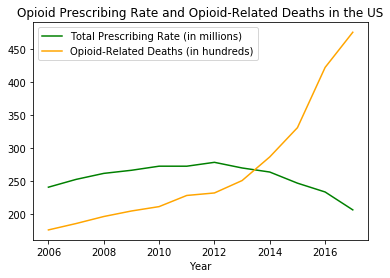

<Figure size 432x288 with 0 Axes>

In [60]:
# Plot the graph
plt.plot(year, rx_rate, color='g', label='Total Prescribing Rate (in millions)')
# OVERLAY SECOND LINE GRAPH:
plt.plot(year, any_opioid, color='orange', label='Opioid-Related Deaths (in hundreds)')
plt.xlabel('Year')
#plt.ylabel('Total Prescribing Rate in the US (in millions)')
plt.title('Opioid Prescribing Rate and Opioid-Related Deaths in the US')
plt.legend()


plt.show()
plt.savefig("Images/OpioidPrescriptionsByYear.png")

In [20]:
df_deaths.head()

,Zipcode,County,Deaths,Population,Crude Rate,% of Total Deaths
0,1003,"Baldwin County, AL",19,212628,Unreliable,0.00%
1,1043,"Cullman County, AL",12,82755,Unreliable,0.00%
2,1049,"DeKalb County, AL",11,71617,Unreliable,0.00%
3,1055,"Etowah County, AL",26,102755,25.3,0.10%
4,1073,"Jefferson County, AL",167,659197,25.3,0.40%


In [21]:
zip_merged.sort_values("FIPS County Code", ascending=True)
#zip_merged.sort_values("FIPS County Code", ascending=True)

,Year,County,State,FIPS County Code,Opioid Prescribing Rate per 100,Zip Code,City,County Name
0,2017,AUTAUGA,AL,1001,106.6,36006,Billingsley,Autauga
60,2009,"Autauga, AL",AL,1001,147.5,36051,Marbury,Autauga
59,2009,"Autauga, AL",AL,1001,147.5,36067,Prattville,Autauga
58,2009,"Autauga, AL",AL,1001,147.5,36091,Verbena,Autauga
57,2009,"Autauga, AL",AL,1001,147.5,36003,Autaugaville,Autauga
56,2009,"Autauga, AL",AL,1001,147.5,36006,Billingsley,Autauga
55,2010,"Autauga, AL",AL,1001,151.7,36749,Jones,Autauga
54,2010,"Autauga, AL",AL,1001,151.7,36066,Prattville,Autauga
53,2010,"Autauga, AL",AL,1001,151.7,36051,Marbury,Autauga
52,2010,"Autauga, AL",AL,1001,151.7,36067,Prattville,Autauga


In [70]:
#new_2017_df = new_zip_merged[new_zip_merged["Year"] == 2017]
df_opioid_deaths

,Year,Total Overdose Deaths,Any Opioid1,Prescription Opioids2,Prescription Opioids AND Other Synthetic Narcotics,Prescription Opioids WITHOUT Other Synthetic Narcotics,Other Synthetic Narcotics (fentanyl)3,Heroin4,Heroin AND Other Synthetic Narcotics,Cocaine AND Any Opioid,Cocaine AND Other Synthetic Narcotics,Psychostimulants With Abuse Potential AND Any Opioid,Psychostimulants With Abuse Potential AND Other Synthetic Narcotics,Benzodiazepines AND Any Opioid,Benzodiazepines AND Other Synthetic Narcotics,Antidepressants AND Any Opioid,Antidepressants AND Other Synthetic Narcotics
0,1999,16849.000000,8048.000000,3442.000000,142.000000,3300.000000,730.000000,1960.000000,15.000000,1964.000000,47.000000,187,11.000000,701.000000,122.000000,611.000000,122.000000
1,2000,17415.000000,8407.000000,3785.000000,167.000000,3618.000000,782.000000,1842.000000,18.000000,1834.000000,46.000000,202,7.000000,892.000000,136.000000,679.000000,123.000000
2,2001,19394.000000,9492.000000,4770.000000,199.000000,4571.000000,957.000000,1779.000000,15.000000,1886.000000,75.000000,164,6.000000,1121.000000,186.000000,890.000000,147.000000
3,2002,23518.000000,11917.000000,6483.000000,322.000000,6161.000000,1295.000000,2089.000000,15.000000,2318.000000,65.000000,325,19.000000,1511.000000,230.000000,1148.000000,238.000000
4,2003,25785.000000,12939.000000,7461.000000,344.000000,7117.000000,1400.000000,2080.000000,16.000000,2456.000000,109.000000,359,28.000000,1692.000000,242.000000,1234.000000,230.000000
5,2004,27424.000000,13755.000000,8577.000000,384.000000,8193.000000,1664.000000,1878.000000,13.000000,2522.000000,130.000000,407,29.000000,2049.000000,270.000000,1379.000000,264.000000
6,2005,29813.000000,14917.000000,9612.000000,426.000000,9186.000000,1742.000000,2009.000000,34.000000,2842.000000,174.000000,476,33.000000,2430.000000,312.000000,1508.000000,278.000000
7,2006,34425.000000,17545.000000,11589.000000,573.000000,11016.000000,2707.000000,2088.000000,113.000000,3372.000000,432.000000,526,37.000000,3045.000000,407.000000,1662.000000,300.000000
8,2007,36010.000000,18515.000000,12796.000000,601.000000,12195.000000,2213.000000,2399.000000,13.000000,3027.000000,219.000000,473,35.000000,3605.000000,436.000000,1901.000000,292.000000
9,2008,36450.000000,19582.000000,13149.000000,655.000000,12494.000000,2306.000000,3041.000000,28.000000,2656.000000,182.000000,495,47.000000,4070.000000,491.000000,2111.000000,384.000000


In [49]:
# Drop rows that only show 2006 - 2017
df_opioid_deaths.head()
df_new_opioid = df_opioid_deaths.drop(df_opioid_deaths.index[[0,1,2,3,4,5,6,19]])
df_new_opioid

,Year,Total Overdose Deaths,Any Opioid1,Prescription Opioids2,Prescription Opioids AND Other Synthetic Narcotics,Prescription Opioids WITHOUT Other Synthetic Narcotics,Other Synthetic Narcotics (fentanyl)3,Heroin4,Heroin AND Other Synthetic Narcotics,Cocaine AND Any Opioid,Cocaine AND Other Synthetic Narcotics,Psychostimulants With Abuse Potential AND Any Opioid,Psychostimulants With Abuse Potential AND Other Synthetic Narcotics,Benzodiazepines AND Any Opioid,Benzodiazepines AND Other Synthetic Narcotics,Antidepressants AND Any Opioid,Antidepressants AND Other Synthetic Narcotics
7,2006,34425.0,17545.0,11589.0,573.0,11016.0,2707.0,2088.0,113.0,3372.0,432.0,526,37.0,3045.0,407.0,1662.0,300.0
8,2007,36010.0,18515.0,12796.0,601.0,12195.0,2213.0,2399.0,13.0,3027.0,219.0,473,35.0,3605.0,436.0,1901.0,292.0
9,2008,36450.0,19582.0,13149.0,655.0,12494.0,2306.0,3041.0,28.0,2656.0,182.0,495,47.0,4070.0,491.0,2111.0,384.0
10,2009,37004.0,20422.0,13523.0,872.0,12651.0,2946.0,3278.0,29.0,2210.0,176.0,654,69.0,4633.0,658.0,2292.0,505.0
11,2010,38329.0,21088.0,14583.0,939.0,13644.0,3007.0,3036.0,45.0,2086.0,167.0,640,73.0,5517.0,746.0,2389.0,568.0
12,2011,41340.0,22784.0,15140.0,889.0,14251.0,2666.0,4397.0,44.0,2505.0,189.0,876,93.0,5826.0,665.0,2501.0,463.0
13,2012,41502.0,23164.0,14240.0,861.0,13379.0,2628.0,5925.0,69.0,2448.0,182.0,993,91.0,5500.0,655.0,2536.0,464.0
14,2013,43982.0,25050.0,14145.0,1015.0,13130.0,3105.0,8257.0,209.0,2831.0,245.0,1354,142.0,5869.0,804.0,2763.0,571.0
15,2014,47055.0,28647.0,14838.0,1489.0,13349.0,5544.0,10574.0,1027.0,3414.0,628.0,1806,276.0,6733.0,1222.0,2983.0,723.0
16,2015,52404.0,33091.0,15281.0,2263.0,13018.0,9580.0,12989.0,2685.0,4506.0,1542.0,2345,494.0,7485.0,1801.0,3062.0,808.0


In [50]:
opioid_deaths_grouped = df_new_opioid.groupby(['Year'])

In [67]:
any_opioid = opioid_deaths_grouped["Any Opioid1"].sum()/100
total_overdose = opioid_deaths_grouped["Total Overdose Deaths"].sum()/100
prescription_opioid = opioid_deaths_grouped["Prescription Opioids2"].sum()/100
synth_narcotics = opioid_deaths_grouped["Other Synthetic Narcotics (fentanyl)3"].sum()/100
heroin = opioid_deaths_grouped["Heroin4"].sum()/100

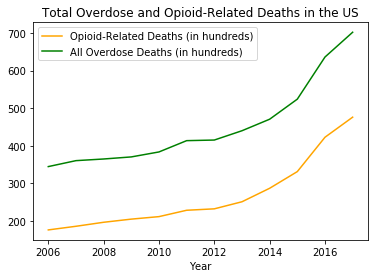

<Figure size 432x288 with 0 Axes>

In [66]:
# Plot graph for Total Overdose and Opioid-Related Deaths in the US
plt.plot(year, any_opioid, color='orange', label='Opioid-Related Deaths (in hundreds)')
plt.plot(year, total_overdose, color='g', label='All Overdose Deaths (in hundreds)')
plt.xlabel('Year')
plt.title('Total Overdose and Opioid-Related Deaths in the US')
plt.legend()


plt.show()
plt.savefig("Images/OpioidOverdoseByYear.png")

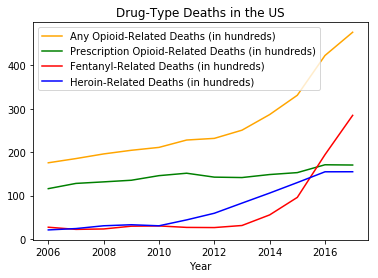

<Figure size 432x288 with 0 Axes>

In [68]:
# Plot Graph for Drug-Type Deaths in US
plt.plot(year, any_opioid, color='orange', label='Any Opioid-Related Deaths (in hundreds)')
plt.plot(year, prescription_opioid, color='g', label='Prescription Opioid-Related Deaths (in hundreds)')
plt.plot(year, synth_narcotics, color='r', label='Fentanyl-Related Deaths (in hundreds)')
plt.plot(year, heroin, color='b', label='Heroin-Related Deaths (in hundreds)')
plt.xlabel('Year')
plt.title('Drug-Type Deaths in the US')
plt.legend()


plt.show()
plt.savefig("Images/DrugDeathsByYear.png")

In [ ]:
# Create dataframes by year 
new_2017_df = new_zip_merged[new_zip_merged["Year"] == 2017]
new_2016_df = new_zip_merged[new_zip_merged["Year"] == 2016]
new_2015_df = new_zip_merged[new_zip_merged["Year"] == 2015]
new_2014_df = new_zip_merged[new_zip_merged["Year"] == 2014]
new_2013_df = new_zip_merged[new_zip_merged["Year"] == 2013]
new_2012_df = new_zip_merged[new_zip_merged["Year"] == 2012]
new_2011_df = new_zip_merged[new_zip_merged["Year"] == 2011]
new_2010_df = new_zip_merged[new_zip_merged["Year"] == 2010]
new_2009_df = new_zip_merged[new_zip_merged["Year"] == 2009]
new_2008_df = new_zip_merged[new_zip_merged["Year"] == 2008]
new_2007_df = new_zip_merged[new_zip_merged["Year"] == 2007]
new_2006_df = new_zip_merged[new_zip_merged["Year"] == 2006]

In [97]:
list(new_2017_df)

['Year',
 'County',
 'State',
 'FIPS County Code',
 'Opioid Prescribing Rate per 100',
 'Zip Code',
 'City',
 'County Name']

In [101]:
# Create heat map for prescription rate per county
new_2017_df['FIPS County Code'] = new_2017_df['FIPS County Code'].apply(lambda x: str(x).zfill(2))

colorscale1 = ["#ffe6e6","#ffcccc","#ffb3b3","#ff9999","#ff8080","#ff6666","#ff4d4d",
              "#ff3333","#ff1a1a","#cc0000","#b30000","#990000","#800000","#660000",
              "#4d0000","#330000","#1a0000"]
endpts1 = list(np.linspace(0, 100, len(colorscale1) - 1))
fips = new_2017_df['FIPS County Code'].tolist()
values1 = new_2017_df['Opioid Prescribing Rate per 100'].tolist()

fig1 = ff.create_choropleth(
    fips=fips, values=values1,
    binning_endpoints=endpts1,
    colorscale=colorscale1,
    show_state_data=False,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='Number of Legal Opioid Prescriptions per 100 Residents by US County in 2017',
    legend_title='Number of Prescriptions per 100 people'
)
py.iplot(fig1, filename='choropleth_full_usa')

C:\Users\T430s\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



NameError: name 'ff' is not defined

In [95]:
#sorted_2017 = new_2017_df.sort_values("Opioid Prescribing Rate per 100", ascending=False)
#grouped_2017 = new_2017_df.groupby(['County'])
#grouped_2017.sum()
#sorted_2017 = grouped_2017.apply.sort_values("Opioid Prescribing Rate per 100", ascending=False)

#new_2017_df.sort_values(['Opioid Prescribing Rate per 100'],ascending=False).groupby('County').head()


#grouped_2017 = new_2017_df.groupby(['FIPS County Code'])
#sorted_2017 = grouped_2017.sort_values("Opioid Prescribing Rate per 100", ascending=False)

#sorted_2017.sum(15)

,Year,County,State,FIPS County Code,Opioid Prescribing Rate per 100,Zip Code,City,County Name
359676,2017,NORTON CITY,VA,51720,396.1,24273,Norton,Norton
359220,2017,GALAX CITY,VA,51640,345.1,24333,Galax,Galax
129492,2017,OWSLEY,KY,21189,229.3,41314,Booneville,Owsley
122223,2017,BELL,KY,21013,228.4,40856,Miracle,Bell
122225,2017,BELL,KY,21013,228.4,40958,Kettle Island,Bell
122228,2017,BELL,KY,21013,228.4,40813,Calvin,Bell
122227,2017,BELL,KY,21013,228.4,40965,Middlesboro,Bell
122226,2017,BELL,KY,21013,228.4,40845,Hulen,Bell
130996,2017,WHITLEY,KY,21235,220.9,40769,Williamsburg,Whitley
130995,2017,WHITLEY,KY,21235,220.9,40759,Rockholds,Whitley
